# Burgers Equation on FLRW Spacetimes
## A Numerical Approach

===== ===== ===== ===== =====

General Burgers: $u_{t} + u\cdot u_{x} - \alpha\cdot u_{xx} = 0$, *where $\alpha =$ diffusion coefficient, and $\alpha = 0$ for Inviscid Burgers*.  Thus,

$u_{t} + u\cdot u_{x} = 0$

On an FLRW background, via Ceylon et al.:

### $a\cdot u_{t}+(1-kr^{2})^{1/2}\cdot \partial_r(\frac{u^2}{2}) + u\cdot (1-\frac{u^{2}}{c^{2}})\cdot \dot{a} = 0$

===== ===== ===== ===== =====

### Library Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

from godunov_burgers import PDE_plotter_1D as Pplot

In [2]:
# Boundary Condition Functions (Direchelet - time domain)
def u_t_0(t):
    return t

def u_t_L(t):
    return t

# Initial Condition Functions
def u_0_x_r(x):
    '''Refraction Wave'''
    if x <= .5:
        return 0
    else:
        return 1
    
def u_0_x_s(x):
    ''''''
    if x <= .5:
        return 1
    else:
        return 0

# FLRW Acceleration Terms - First Order
def a_scale(t, alpha):
    return t**alpha ######

def a_scale_t(t, alpha, t0=1):
    return 0 ######

# Function to calculate the flux
def calculate_flux(u, r, k, a):
    return (1 - k * r**2)**0.5 * u**2 / (2 * a)

# Function to calculate wave speeds
def calculate_wave_speeds(u, r, k, c, a, a_t):
    wave_speed_1 = abs((1 - k * r**2)**0.5 * u / a)
    wave_speed_2 = abs(u * (1 - (u**2 / c**2)) * a_t / a)
    return wave_speed_1, wave_speed_2

# Precompute the maximum wave speeds over the domain and time interval
def precompute_max_wave_speed(u_initial, r, k, c, a_scale, a_scale_t, alpha, t_max):
    max_speed = 0
    t_values = np.linspace(0.00001, t_max, 100)  # Discretize the time interval

    for t in t_values:
        a = a_scale(t,alpha)
        a_t = a_scale_t(t,alpha)
        for i in range(len(u_initial)):
            wave_speed_1, wave_speed_2 = calculate_wave_speeds(u_initial[i], r[i], k, c, a, a_t)
            max_speed = max(max_speed, wave_speed_1, wave_speed_2)

    return max_speed

# Define the HLL flux calculation with correct r interface handling
def hll_flux(u_left, u_right, r_left, r_right, k, a, a_t):
    r_interface = (r_left + r_right) / 2
    f_left = calculate_flux(u_left, r_interface, k, a_t)
    f_right = calculate_flux(u_right, r_interface, k, a_t)
    s_left, s_right = calculate_wave_speeds(u_left, r_interface, k, c, a, a_t)
                      
    if s_left >= 0:
        return f_left
    elif s_right <= 0:
        return f_right
    else:
        return (s_right * f_left - s_left * f_right + s_left * s_right * (u_right - u_left)) / (s_right - s_left)

# Godunov scheme implementation with time-dependent a and a_dot
def godunov_scheme(u0, r, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max):
    U = []
    U.append(u0)
    u = u0.copy()
    t = 0
    while t < t_max + dt:
        t += dt
        u_new = u.copy()

        for i in range(1, len(u) - 1):
            r_left = r[i - 1]
            r_center = r[i]
            r_right = r[i + 1]

            F_i_plus_1_2 = hll_flux(u[i], u[i + 1], r_center, r_right, k, a_scale(t, alpha), a_scale_t(t,alpha))
            F_i_minus_1_2 = hll_flux(u[i - 1], u[i], r_left, r_center, k, a_scale(t, alpha), a_scale_t(t,alpha))

            source_term = u[i] * (1 - (u[i]**2 / c**2)) * a_scale_t(t, alpha) / a_scale(t, alpha)
            u_new[i] = u[i] - (dt / dr) * (F_i_plus_1_2 - F_i_minus_1_2) - dt * source_term
                
        u = u_new.copy()
        
        U.append(u)
    
    return U

In [3]:
a_scale(10, 0)

a_scale_t(10,0)

# def a_scale_t(t, alpha, t0=1):
#     return alpha * t**(alpha - 1)


0

#### ----

In [4]:
t_max = 1
L = 1
dr = .020
Nr = int(L/dr)
r_grid = np.linspace(0,L,Nr+1)
c = 1

## For Rarefaction:
# Using Initial Conditions, Create u0 (needs u_0_x)
u0r = [u_0_x_r(r) for r in r_grid]

# Set the boundary conditions
u0r[0] = u_t_0(0)
u0r[-1] = u_t_L(1)

## For Shockwave:
# Using Initial Conditions, Create u0 (needs u_0_x)
u0s = [u_0_x_s(r) for r in r_grid]

# Set the boundary conditions
u0s[0] = u_t_0(1)
u0s[-1] = u_t_L(0)

#### ----

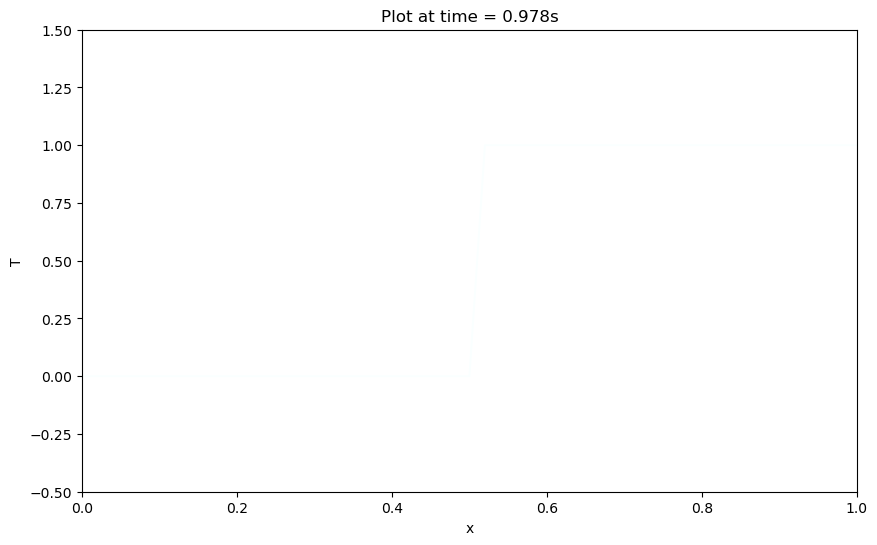

In [5]:
alpha = 0
Ur = []

for k in [-1,0,1]:
    print(f'k = {k}, alpha = {alpha}')
    time.sleep(1)
    max_speed = precompute_max_wave_speed(u0r, r_grid, k, c, a_scale, a_scale_t, alpha, t_max)
    dt = dr / max_speed
    try:
        U = godunov_scheme(u0r, r_grid, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max)
        Ur.append(U)
    except:
        print(f'Fails for k = {k} and alpha = {alpha}')
        Ur.append('Fail')
        continue

    try:
        Pplot(U, L, t_max, 10, 0, t_max, 0, L, style = 'multi', alpha_decay = .7)
    except:

        print(f'Fails for k = {k} and alpha = {alpha}')
        continue

In [ ]:
alpha = 1
Us = []

for k in [-1,0,1]:
    print(f'k = {k}, alpha = {alpha}')
    time.sleep(1)
    max_speed = precompute_max_wave_speed(u0s, r_grid, k, c, a_scale, a_scale_t, alpha, t_max)
    dt = dr / max_speed
    try:
        U = godunov_scheme(u0s, r_grid, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max)
        Us.append(U)
    except:
        print(f'Fails for k = {k} and alpha = {alpha}')
        Us.append('Fail')
        continue

    try:
        Pplot(U, L, t_max, 10, 0, t_max, 0, L, style = 'multi', alpha_decay = .7)
    except:

        print(f'Fails for k = {k} and alpha = {alpha}')
        continue

k = -1, alpha = 1


/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_82816/1301303932.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 - k * r**2)**0.5 * u**2 / (2 * a)
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_82816/1301303932.py:87: RuntimeWarning: invalid value encountered in scalar subtract
  u_new[i] = u[i] - (dt / dr) * (F_i_plus_1_2 - F_i_minus_1_2) - dt * source_term
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_82816/1301303932.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return (1 - k * r**2)**0.5 * u**2 / (2 * a)


Fails for k = -1 and alpha = 1
k = 0, alpha = 1


In [ ]:
Us

In [ ]:
k = -1
c = 1
alpha = 0

max_speed = precompute_max_wave_speed(u0, r_grid, k, c, a_scale, a_scale_t, alpha, t_max)
dt = dr / max_speed

U = godunov_scheme(u0, r_grid, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max)
Pplot(U, L, t_max, 10, 0, t_max/2, 0, L, style = 'multi', alpha_decay = .7)

print('dt =',dt)

-----

In [ ]:
# Boundary Condition Functions (Direchelet - time domain)
def u_t_0(t):
    return t

def u_t_L(t):
    return t

# Initial Condition Function
def u_0_x(x):
    if x < .3:
        return 0
    else:
        return 1

# FLRW Acceleration Terms - First Order
def a_scale(t, alpha, a0=1, t0=1):
    return 1 + t**alpha

def a_scale_t(t, alpha, a0=1, t0=1):
    return alpha * t**(alpha - 1)

In [ ]:
# Function to calculate the flux
def calculate_flux(u, r, k, a_t):
    return (1 - k * r**2)**0.5 * u**2 / (2 * a_t)

# Function to calculate wave speeds
def calculate_wave_speeds(u, r, k, c, a, a_t):
    wave_speed_1 = abs((1 - k * r**2)**0.5 * u / a)
    wave_speed_2 = abs(u * (1 - (u**2 / c**2)) * a_t / a)
    return wave_speed_1, wave_speed_2

# Precompute the maximum wave speeds over the domain and time interval
def precompute_max_wave_speed(u_initial, r, k, c, a_scale, a_scale_t, alpha, t_max):
    max_speed = 0
    t_values = np.linspace(0, t_max, 100)  # Discretize the time interval

    for t in t_values:
        a = a_scale(t,alpha)
        a_t = a_scale_t(t,alpha)
        for i in range(len(u_initial)):
            wave_speed_1, wave_speed_2 = calculate_wave_speeds(u_initial[i], r[i], k, c, a, a_t)
            max_speed = max(max_speed, wave_speed_1, wave_speed_2)

    return max_speed

In [ ]:
L = 1
dr = .05
Nr = int(L/dr)
r_grid = np.linspace(0,L,Nr+1)

In [ ]:
# Using Initial Conditions, Create u0 (needs u_0_x)
u0 = [u_0_x(x) for x in r_grid]

# Set the boundary conditions
u0[0] = u_t_0(0)
u0[-1] = u_t_L(1)

u0

In [ ]:
k = 0
c = 1
alpha = 1
t_max = 1

max_speed = precompute_max_wave_speed(u0, r_grid, k, c, a_scale, a_scale_t, alpha, t_max)
dt = dr / max_speed

In [ ]:
# Define the HLL flux calculation with correct r interface handling
def hll_flux(u_left, u_right, r_left, r_right, k, a, a_t):
    r_interface = (r_left + r_right) / 2
    f_left = calculate_flux(u_left, r_interface, k, a_t)
    f_right = calculate_flux(u_right, r_interface, k, a_t)
    s_left, s_right = calculate_wave_speeds(u_left, r_interface, k, c, a, a_t)
                      
    if s_left >= 0:
        return f_left
    elif s_right <= 0:
        return f_right
    else:
        return (s_right * f_left - s_left * f_right + s_left * s_right * (u_right - u_left)) / (s_right - s_left)

# Godunov scheme implementation with time-dependent a and a_dot
def godunov_scheme(u0, r, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max):
    U = []
    U.append(u0)
    u = u0.copy()
    t = 0
    while t < t_max:
        t += dt
        u_new = u.copy()

        for i in range(1, len(u) - 1):
            r_left = r[i - 1]
            r_center = r[i]
            r_right = r[i + 1]

            F_i_plus_1_2 = hll_flux(u[i], u[i + 1], r_center, r_right, k, a_scale(t, alpha), a_scale_t(t,alpha))
            F_i_minus_1_2 = hll_flux(u[i - 1], u[i], r_left, r_center, k, a_scale(t, alpha), a_scale_t(t,alpha))

            source_term = u[i] * (1 - (u[i]**2 / c**2)) * a_scale_t(t, alpha) / a_scale(t, alpha)
            u_new[i] = u[i] - (dt / dr) * (F_i_plus_1_2 - F_i_minus_1_2) - dt * source_term
                
        u = u_new.copy()
        
        U.append(u)
    
    return U

In [ ]:
U = godunov_scheme(u0, r_grid, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max)

In [ ]:
steps = 20
t_min_plot = 0
t_max_plot = t_max
x_min_plot = 0
x_max_plot = L

Pplot(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, style = 'multi', alpha_decay = .7)

In [ ]:
c = []
for i in range(1, 50):
    a = i*(1/i**.5)
    print(i,' - ',a)
    c.append(a)

In [ ]:
plt.plot(c)

In [ ]:
# Keep this!
Ur = []

for k in [-1,0,1]:
    for alpha in [0, .5, 1]:
        print(f'k = {k}, alpha = {alpha}')
        time.sleep(1)
        max_speed = precompute_max_wave_speed(u0r, r_grid, k, c, a_scale, a_scale_t, alpha, t_max)
        dt = dr / max_speed
        try:
            U = godunov_scheme(u0r, r_grid, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max)
            Ur.append(U)
        except:
            print(f'Fails for k = {k} and alpha = {alpha}')
            Ur.append('Fail')
            continue
        
        try:
            Pplot(U, L, t_max, 10, 0, t_max, 0, L, style = 'multi', alpha_decay = .7)
        except:
            
            print(f'Fails for k = {k} and alpha = {alpha}')
            continue